In [1]:
# load data

import glob
import os

cars = []
notcars = []

vehicles_dir = "C:\\Users\\AW51R2\\code\\carnd\\CarND-Vehicle-Detection\\vehicles\\vehicles\\KITTI_extracted"

images = glob.glob(os.path.join(vehicles_dir, '*.PNG'))
for image in images:
    cars.append(image)

non_vehicles_dir = "C:\\Users\\AW51R2\\code\\carnd\\CarND-Vehicle-Detection\\non-vehicles\\non-vehicles\\Extras"

images = glob.glob(os.path.join(non_vehicles_dir, '*.PNG'))
for image in images:
    notcars.append(image)

        
        
print("cars: ", len(cars))
print("notcars: ", len(notcars))

cars:  5966
notcars:  5068


In [2]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [3]:
#utility functions
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        file_features = extract_features_image(image, color_space, spatial_size,
                                              hist_bins, orient,
                                              pix_per_cell,cell_per_block,hog_channel,
                                              spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    return features

def extract_features_image(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    # apply color conversion if other than 'RGB'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # [0,255]
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    feature_image = feature_image[:,:,0]
    
    if spatial_feat == True:
        spatial_features = bin_spatial(image, size=spatial_size)
        file_features.append(spatial_features)

    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(image, nbins=hist_bins)
        file_features.append(hist_features)

    if hog_feat == True: # we know it's gray
        hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)    
        file_features.append(hog_features)
    return np.concatenate(file_features)
    



In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window
        features = extract_features_image(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #prediction_prob = clf.predict_proba(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
        #if prediction_prob[0][0] > 0.9:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [7]:
#parameters
### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print("cars:", len(cars))
print("notcars:", len(notcars))



car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("done!")

cars: 5966
notcars: 5068
done!


In [8]:
# train SVC
# Split up data into randomized training and test sets
from sklearn.svm import SVC

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC(kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample





Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
12.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9923


In [9]:
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 1.  0.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  0.  0.  0.  1.  0.]
0.01503 Seconds to predict 10 labels with SVC


In [ ]:
# save model
from sklearn.externals import joblib
# now you can save it to a file
joblib.dump(svc, 'svc.pkl') 

In [ ]:
from sklearn.externals import joblib
# load model
# and later you can load it
svc = joblib.load('svc.pkl')

In [10]:
# heatmaps
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
%matplotlib inline
image = mpimg.imread('test_images/test6.jpg')
image_color = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plt.imshow(image_color)
R = image_color[:,:,0]
plt.imshow(R)

test_images\test1.jpg


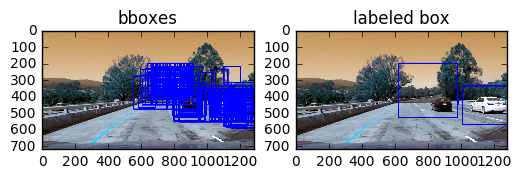

test_images\test2.jpg


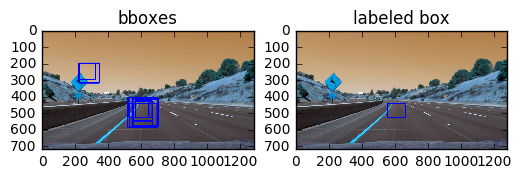

test_images\test3.jpg


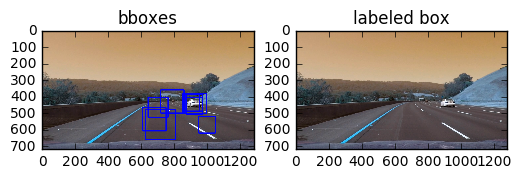

test_images\test4.jpg


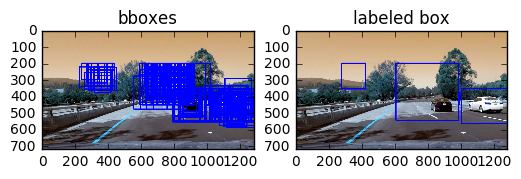

test_images\test5.jpg


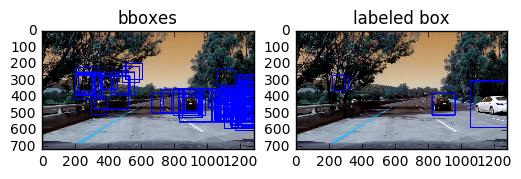

test_images\test6.jpg


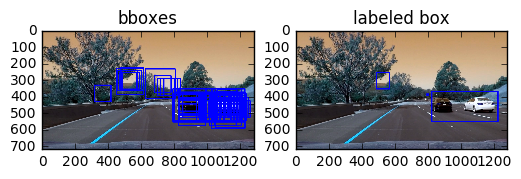

In [11]:
%matplotlib inline
# test image
images = glob.glob('test_images/*.jpg')

dimensions = [(100,100),(120,120),(140,140),(160,160),(180,180),(200,200)]

y_start_stop = [200,600]

for idx, fname in enumerate(images):
    print(fname)
    image = cv2.imread(fname)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    
    bboxes = []
    
    for dimension in dimensions:

        windows = slide_window(image, x_start_stop=[200, None], y_start_stop=y_start_stop, 
                            xy_window=dimension, xy_overlap=(0.8, 0.8))

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat) 
        
        bboxes += hot_windows
        
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    window_img = draw_boxes(draw_image, bboxes, color=(0, 0, 255), thick=6)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(idx+1)
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('bboxes')
    plt.subplot(122)
    plt.imshow(draw_img)
    plt.title('labeled box')
    #plt.subplot(133)
    #plt.imshow(heatmap, cmap='hot')
    #plt.title('Heat Map')
    #fig.tight_layout()
    plt.show()

In [ ]:
image = cv2.imread('C:\\Users\\AW51R2\\code\\carnd\\CarND-Vehicle-Detection\\vehicles\\vehicles\\KITTI_extracted\\1269.png')
#image = image*255
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
converted = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

print(image)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(converted)

C:\Users\AW51R2\code\carnd\CarND-Vehicle-Detection\vehicles\vehicles\KITTI_extracted\3994.png
C:\Users\AW51R2\code\carnd\CarND-Vehicle-Detection\vehicles\vehicles\KITTI_extracted\5647.png
C:\Users\AW51R2\code\carnd\CarND-Vehicle-Detection\vehicles\vehicles\KITTI_extracted\870.png
C:\Users\AW51R2\code\carnd\CarND-Vehicle-Detection\vehicles\vehicles\KITTI_extracted\1569.png
C:\Users\AW51R2\code\carnd\CarND-Vehicle-Detection\vehicles\vehicles\KITTI_extracted\4152.png


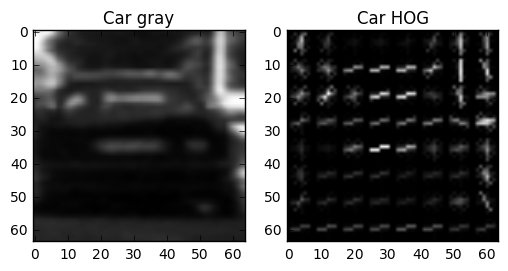

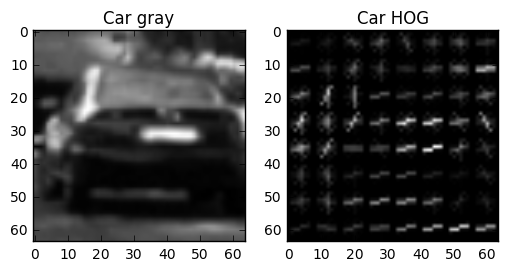

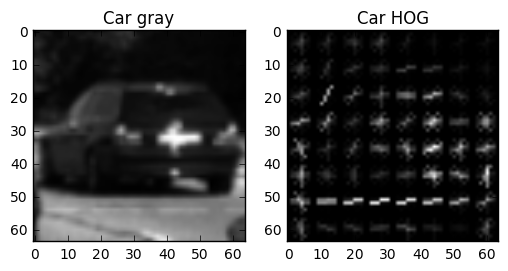

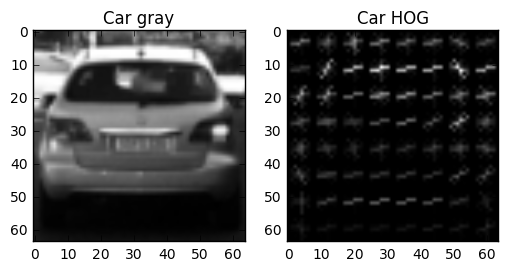

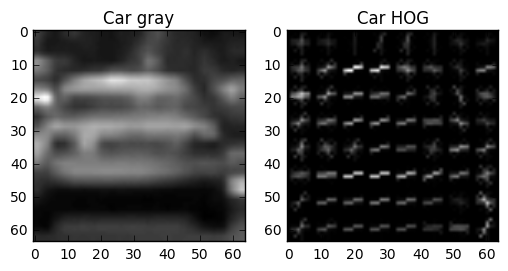

In [12]:
%matplotlib inline
# sample of HOG
# Generate a random index to look at a car image
for i in range(5):
    ind = np.random.randint(0, len(cars))
    print(cars[ind])
    # Read in the image
    image = cv2.imread(cars[ind])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB, HSV, LUV, HLS, YUV, YCrCb
    # TODO: this is gray space
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    r = gray[:,:,0]
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(r, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)


    # Plot the examples
    fig = plt.figure(i)
    plt.subplot(121)
    plt.imshow(r,cmap='gray')
    plt.title('Car gray')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('Car HOG')

In [ ]:
%matplotlib inline
# sample of HOG
# Generate a random index to look at a car image
for i in range(5):
    ind = np.random.randint(0, len(notcars))
    print(notcars[ind])
    # Read in the image
    image = mpimg.imread(notcars[ind])
    # TODO: this is gray space
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    r = gray[:,:,0]
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(r, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)


    # Plot the examples
    fig = plt.figure(i)
    plt.subplot(121)
    plt.imshow(r, cmap='gray')
    plt.title('Not Car gray')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('Not Car HOG')